In [1]:
from pyspark.sql import SparkSession, DataFrame, functions as F
from pyspark.ml.feature import Imputer, StringIndexer, VectorIndexer, VectorAssembler, PCA, Bucketizer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

import pandas as pd
import pandas_profiling
import os

In [2]:
from pyspark.ml.feature import OneHotEncoder

In [3]:
for dirname, _, filenames in os.walk(r'C:\Users\risha\OneDrive\Desktop\pyspark\EDA'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\risha\OneDrive\Desktop\pyspark\EDA\gender_submission.csv
C:\Users\risha\OneDrive\Desktop\pyspark\EDA\test.csv
C:\Users\risha\OneDrive\Desktop\pyspark\EDA\train.csv


In [4]:
# For visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
spark = SparkSession.builder.appName("EDA_on_Titanic_Dataset").config('spark.driver.memory','15g').getOrCreate()
spark

In [6]:
sdf_train = spark.read.csv(r'C:\Users\risha\OneDrive\Desktop\pyspark\EDA\train.csv', inferSchema = True, header = True)
sdf_test = spark.read.csv(r'C:\Users\risha\OneDrive\Desktop\pyspark\EDA\test.csv', inferSchema = True, header = True)

In [7]:
def _clean_dataset(sdf: DataFrame, col_to_convert: list, col_to_impute: list) -> DataFrame:
    for col in col_to_convert:
        sdf = sdf.withColumn(col,sdf[col].cast('double'))
    col_to_impute += col_to_convert

    imputer = Imputer(inputCols = col_to_impute, outputCols = col_to_impute)
    sdf = imputer.fit(sdf).transform(sdf)
    
    return sdf

In [8]:
def _handle_missing_age(sdf: DataFrame) -> DataFrame:
    _sdf = sdf
    _sdf = _sdf.withColumn('Age', 
           F.when((F.isnull(_sdf['Age'])) & (_sdf['Initial'] == 'Mr') , 33 )\
            .otherwise(F.when((F.isnull(_sdf['Age'])) 
                              & (_sdf['Initial'] == 'Mrs') , 36)\
            .otherwise(F.when((F.isnull(_sdf['Age'])) 
                              & (_sdf['Initial'] == 'Master') , 5)\
            .otherwise(F.when((F.isnull(_sdf['Age'])) 
                              & (_sdf['Initial'] == 'Miss') , 22)\
            .otherwise(F.when((F.isnull(_sdf['Age'])) 
                              & (_sdf['Initial'] == 'Other') , 46)\
            .otherwise(_sdf['Age']) )))))
    return _sdf

In [9]:
def _evaluate_initials(sdf: DataFrame) -> DataFrame:
    dizip_initials = {k:v for k,v in (zip(['Mlle','Mme','Ms','Dr',
                                           'Major','Lady','Countess',
                                           'Jonkheer','Col','Rev',
                                           'Capt','Sir','Don'],
                                         ['Miss','Miss','Miss',
                                          'Mr','Mr','Mrs','Mrs',
                                          'Other','Other','Other',
                                          'Mr','Mr','Mr']))}
    _sdf = sdf.withColumn('Initial',  F.regexp_extract( sdf['Name'], ('([A-Za-z]+)\.'),1 ) )
    _sdf = _sdf.replace(dizip_initials,1,'Initial')
    return _sdf

In [10]:
def _create_family_size(sdf: DataFrame) -> DataFrame :
    _sdf = sdf.withColumn('FamilySize', sdf['Parch'] + sdf['SibSp'] + 1 )
    
    return _sdf

In [11]:
sdf_train_cleaned = _clean_dataset ( 
    _handle_missing_age(
    _evaluate_initials(
    _create_family_size(sdf_train)
    )) 
    ,['Ticket','SibSp','Parch'],['Fare'] 
)

sdf_test_cleaned = _clean_dataset ( 
    _handle_missing_age(
    _evaluate_initials(
    _create_family_size(sdf_test)
    )) 
    ,['Ticket','SibSp','Parch'],['Fare'] 
)

sdf_train_cleaned.limit(5).toPandas().T

C:\Users\risha\anaconda3\lib\site-packages\pyspark\sql\dataframe.py:2722: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1.0,1.0,0.0,1.0,0.0
Parch,0.0,0.0,0.0,0.0,0.0
Ticket,260318.549168,260318.549168,260318.549168,113803.0,373450.0
Fare,7.25,71.2833,7.925,53.1,8.05


In [12]:
pdf_sdf_train = sdf_train_cleaned.toPandas()
pdf_sdf_train.T

,0,1,2,3,4,5,6,7,8,9,...,881,882,883,884,885,886,887,888,889,890
PassengerId,1,2,3,4,5,6,7,8,9,10,...,882,883,884,885,886,887,888,889,890,891
Survived,0,1,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
Pclass,3,1,3,1,3,3,1,3,3,2,...,3,3,2,3,3,2,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry","Moran, Mr. James","McCarthy, Mr. Timothy J","Palsson, Master. Gosta Leonard","Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)","Nasser, Mrs. Nicholas (Adele Achem)",...,"Markun, Mr. Johann","Dahlberg, Miss. Gerda Ulrika","Banfield, Mr. Frederick James","Sutehall, Mr. Henry Jr","Rice, Mrs. William (Margaret Norton)","Montvila, Rev. Juozas","Graham, Miss. Margaret Edith","""Johnston, Miss. Catherine Helen """"Carrie""""""","Behr, Mr. Karl Howell","Dooley, Mr. Patrick"
Sex,male,female,female,female,male,male,male,male,female,female,...,male,female,male,male,female,male,female,female,male,male
Age,22.0,38.0,26.0,35.0,35.0,33.0,54.0,2.0,27.0,14.0,...,33.0,22.0,28.0,25.0,39.0,27.0,19.0,22.0,26.0,32.0
SibSp,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Parch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0
Ticket,260318.549168,260318.549168,260318.549168,113803.0,373450.0,330877.0,17463.0,349909.0,347742.0,237736.0,...,349257.0,7552.0,260318.549168,260318.549168,382652.0,211536.0,112053.0,260318.549168,111369.0,370376.0
Fare,7.25,71.2833,7.925,53.1,8.05,8.4583,51.8625,21.075,11.1333,30.0708,...,7.8958,10.5167,10.5,7.05,29.125,13.0,30.0,23.45,30.0,7.75


C:\Users\risha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'violinplot: Age ratio with Initial'}, xlabel='Initial', ylabel='Age'>

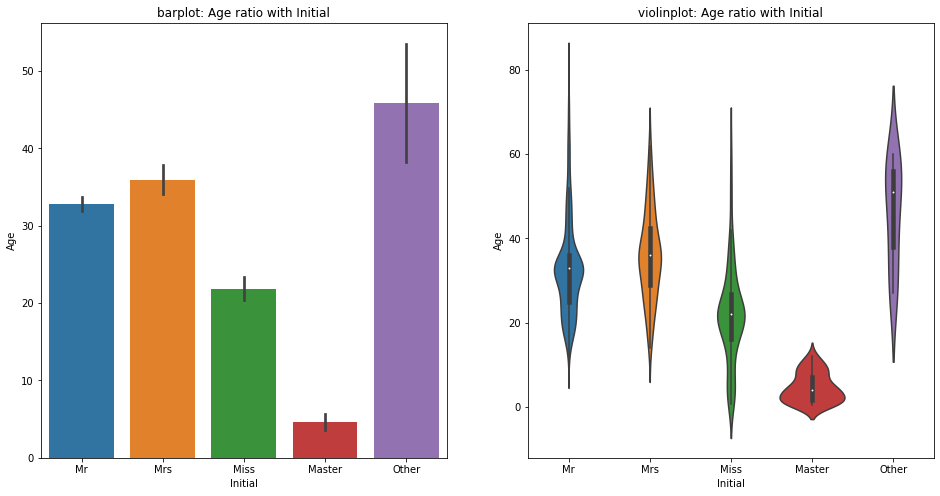

In [13]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: Age ratio with Initial')
sns.barplot(x= pdf_sdf_train['Initial'], y=pdf_sdf_train['Age'],ax=ax[0])

ax[1].set_title('violinplot: Age ratio with Initial')
sns.violinplot(pdf_sdf_train['Initial'],pdf_sdf_train['Age'], ax=ax[1])

In [14]:
# derive AgeGroup from age and sex
pdf_sdf_train['AgeGroup'] = None
pdf_sdf_train.loc[((pdf_sdf_train['Sex'] == 'male') & (pdf_sdf_train['Age'] <= 15)), 'AgeGroup'] = 'boy'
pdf_sdf_train.loc[((pdf_sdf_train['Sex'] == 'female') & (pdf_sdf_train['Age'] <= 15)), 'AgeGroup'] = 'girl'
pdf_sdf_train.loc[((pdf_sdf_train['Sex'] == 'male') & (pdf_sdf_train['Age'] > 15)), 'AgeGroup'] = 'adult male'
pdf_sdf_train.loc[((pdf_sdf_train['Sex'] == 'female') & (pdf_sdf_train['Age'] > 15)), 'AgeGroup'] = 'adult female'
pdf_sdf_train['AgeGroup'].value_counts()

adult male      533
adult female    271
boy              44
girl             43
Name: AgeGroup, dtype: int64

C:\Users\risha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\risha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'countplot: Survived ratio for Age group'}, xlabel='AgeGroup', ylabel='count'>

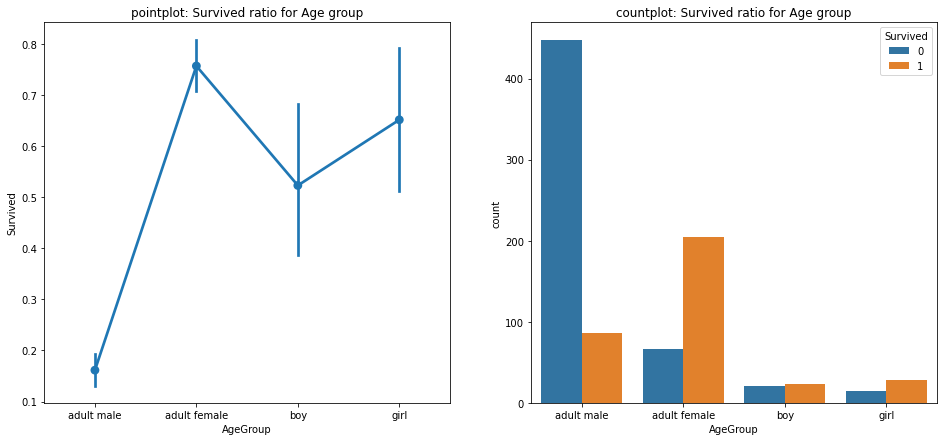

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16,7))
ax[0].set_title('pointplot: Survived ratio for Age group')
sns.pointplot(pdf_sdf_train['AgeGroup'],pdf_sdf_train['Survived'],ax=ax[0])
ax[1].set_title('countplot: Survived ratio for Age group')
sns.countplot(pdf_sdf_train['AgeGroup'],hue= pdf_sdf_train['Survived'],ax=ax[1])

C:\Users\risha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\risha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'countplot: Survived ratio with Pclass'}, xlabel='Pclass', ylabel='count'>

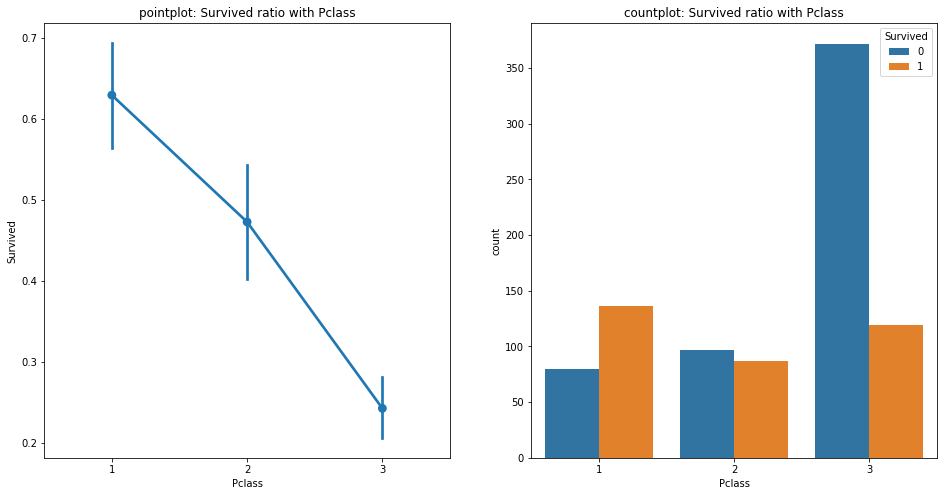

In [16]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].set_title('pointplot: Survived ratio with Pclass')
sns.pointplot(pdf_sdf_train['Pclass'],pdf_sdf_train['Survived'],ax=ax[0])
ax[1].set_title('countplot: Survived ratio with Pclass')
sns.countplot(pdf_sdf_train['Pclass'],hue= pdf_sdf_train['Survived'],ax=ax[1])

C:\Users\risha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'countplot: Survived ratio with Pclass'}, xlabel='Pclass', ylabel='count'>

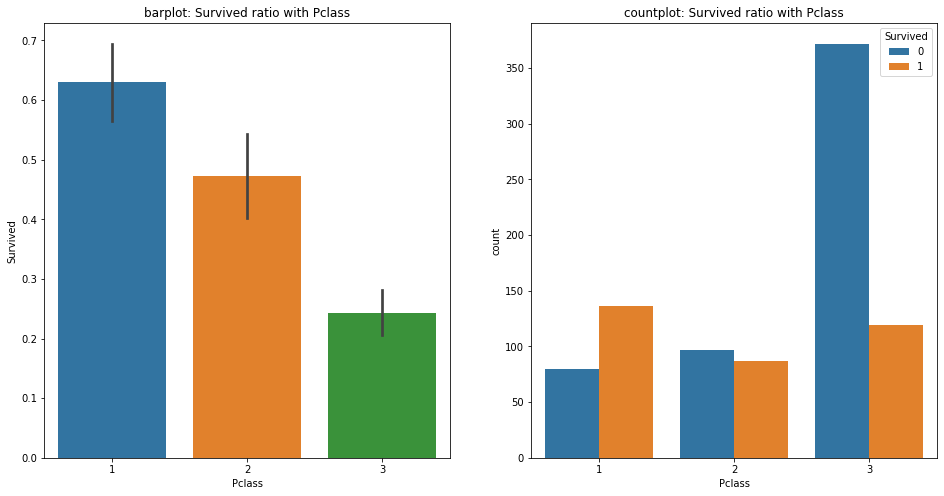

In [17]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: Survived ratio with Pclass')
sns.barplot( pdf_sdf_train['Pclass'], pdf_sdf_train['Survived'], ax=ax[0])

ax[1].set_title('countplot: Survived ratio with Pclass')
sns.countplot(x=pdf_sdf_train['Pclass'], hue=pdf_sdf_train['Survived'], ax=ax[1])

C:\Users\risha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'barplot: Survived ratio with Sex'}, xlabel='Sex', ylabel='Survived'>

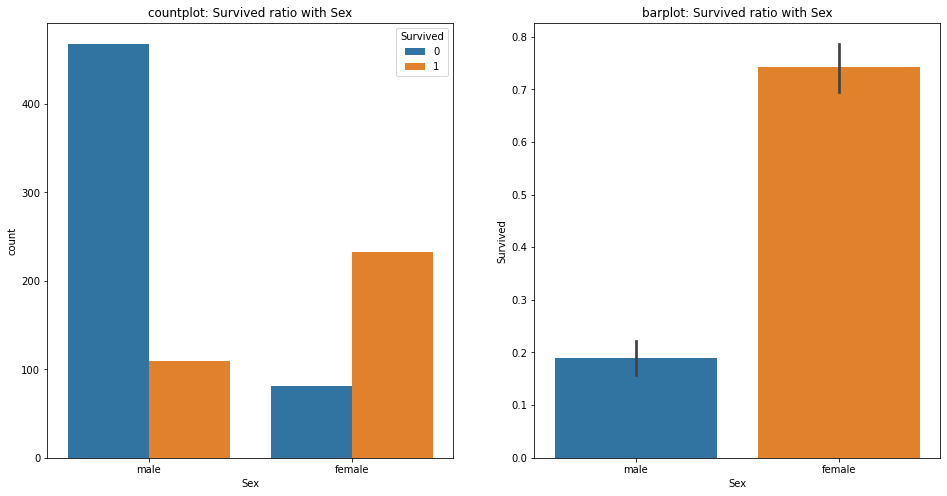

In [18]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('countplot: Survived ratio with Sex')
sns.countplot(x=pdf_sdf_train['Sex'],hue= pdf_sdf_train['Survived'],ax=ax[0])

ax[1].set_title('barplot: Survived ratio with Sex')
sns.barplot(pdf_sdf_train['Sex'], pdf_sdf_train['Survived'],ax=ax[1])

<AxesSubplot:xlabel='count', ylabel='Age'>

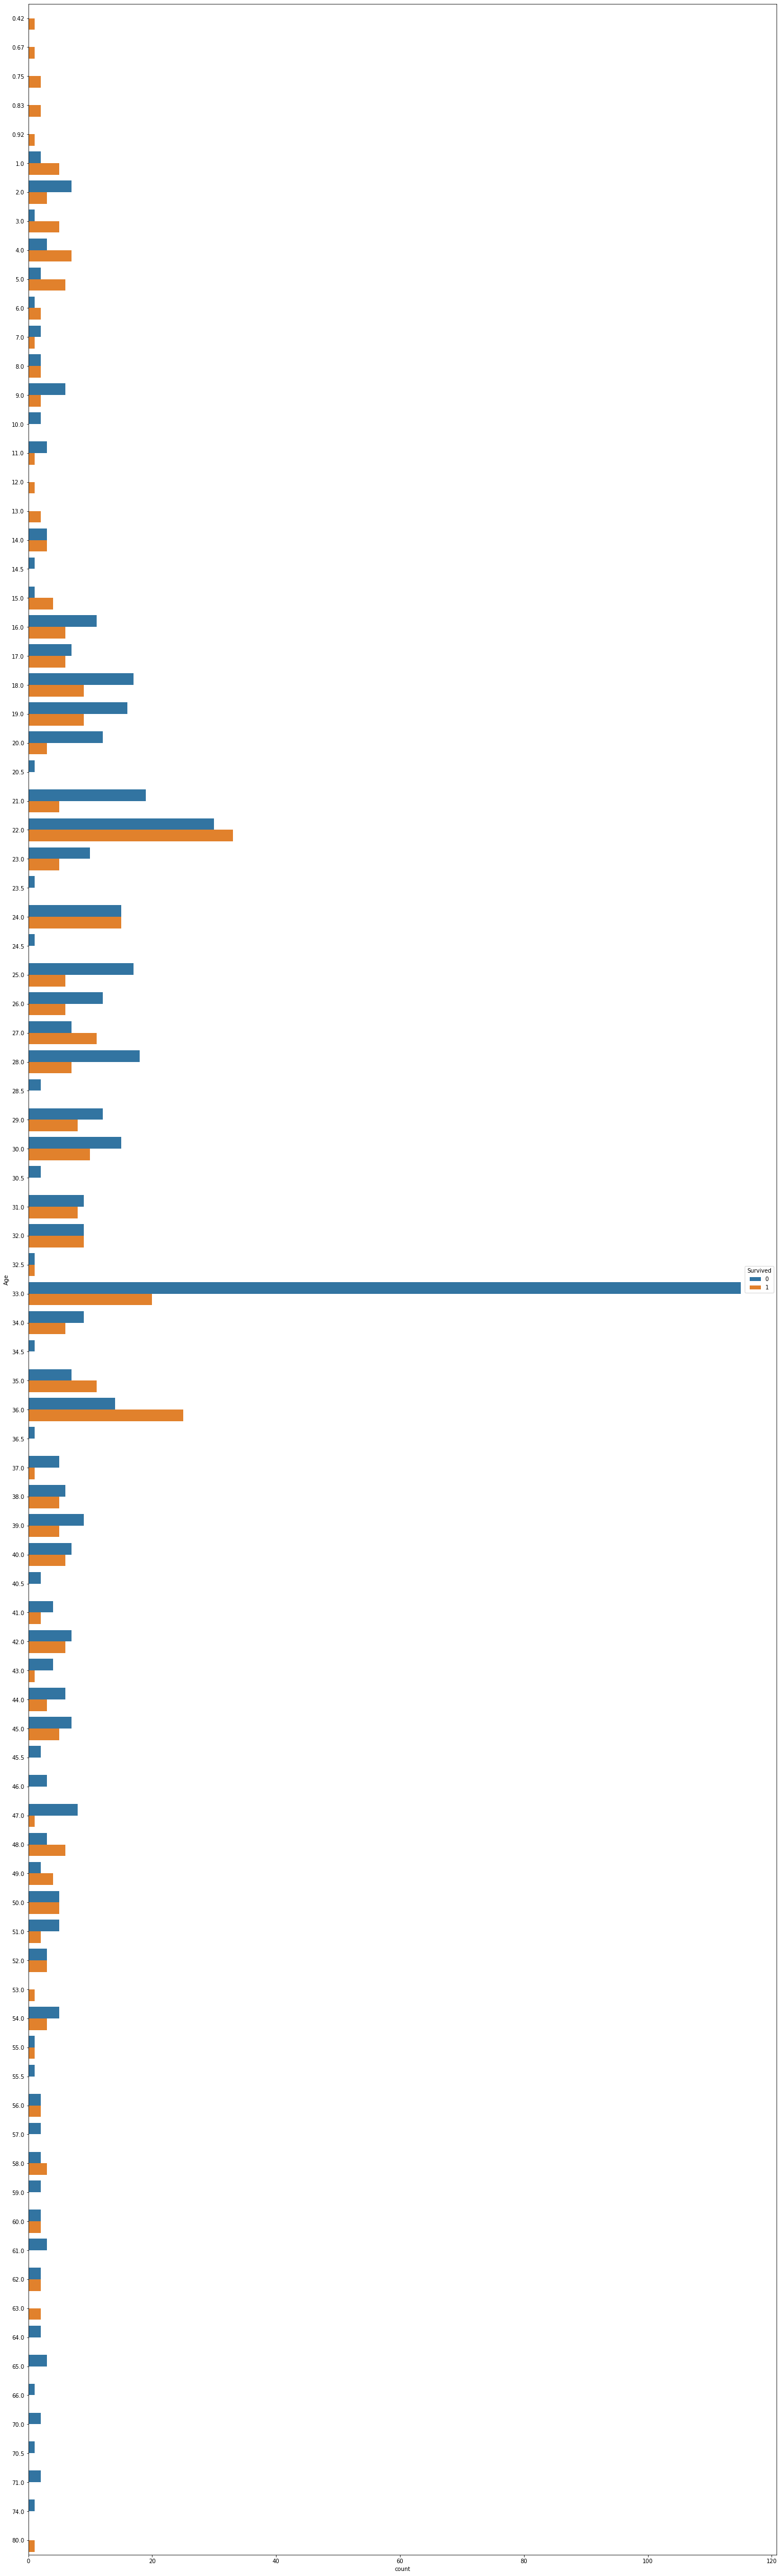

In [19]:
plt.figure(figsize=(24,84))
sns.countplot(y=pdf_sdf_train['Age'],hue= pdf_sdf_train['Survived'],orient='h')

In [20]:
pd.Categorical(pdf_sdf_train['Sex'])

['male', 'female', 'female', 'female', 'male', ..., 'male', 'female', 'female', 'male', 'male']
Length: 891
Categories (2, object): ['female', 'male']

16
65


C:\Users\risha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age', ylabel='Survived'>

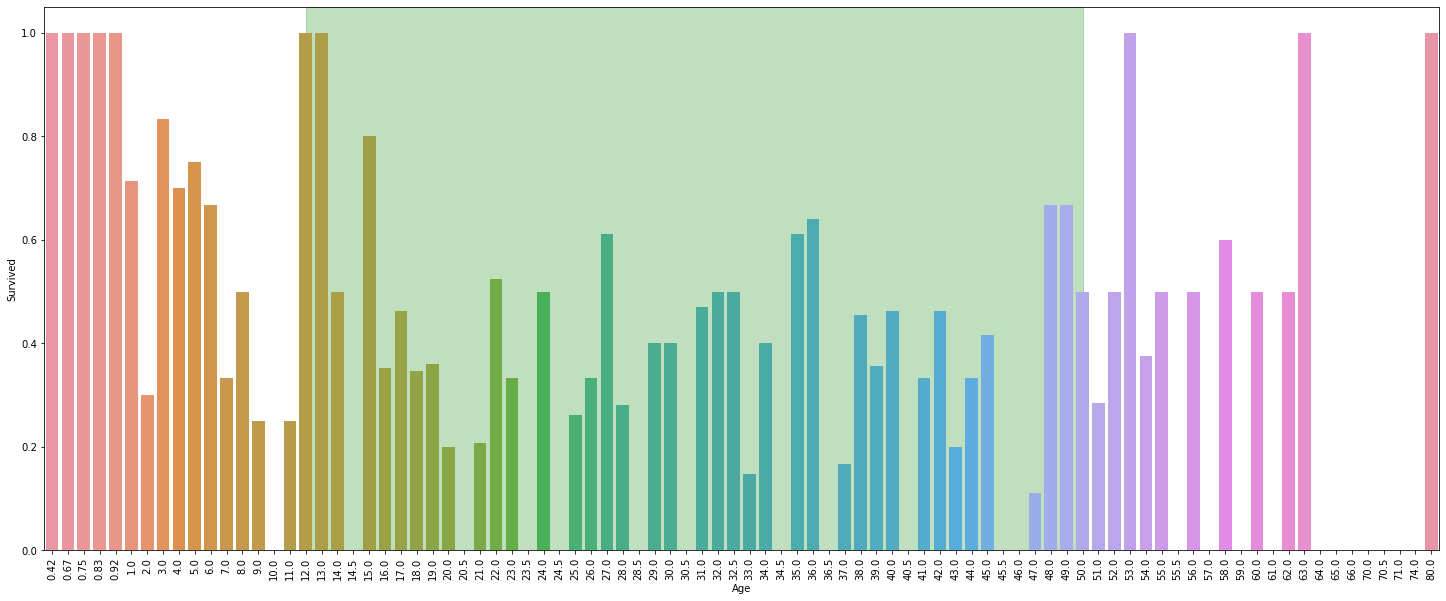

In [21]:
import numpy as np
plt.figure(figsize=(25,10))
plt.xticks(rotation=90)
plt.axvspan(np.size(pdf_sdf_train[pdf_sdf_train['Age'] < 12]['Age'].unique())
            ,np.size(pdf_sdf_train[pdf_sdf_train['Age'] < 50]['Age'].unique())
            ,alpha = 0.25
            , color = 'green') # without alpha = 0.25, it will be dark green!
print(np.size(pdf_sdf_train[pdf_sdf_train['Age'] < 12]['Age'].unique()))
print(np.size(pdf_sdf_train[pdf_sdf_train['Age'] < 50]['Age'].unique()))

sns.barplot(pdf_sdf_train['Age'],pdf_sdf_train['Survived'], ci=None)

C:\Users\risha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Age distribution among all Pasengers'}, xlabel='Age', ylabel='Density'>

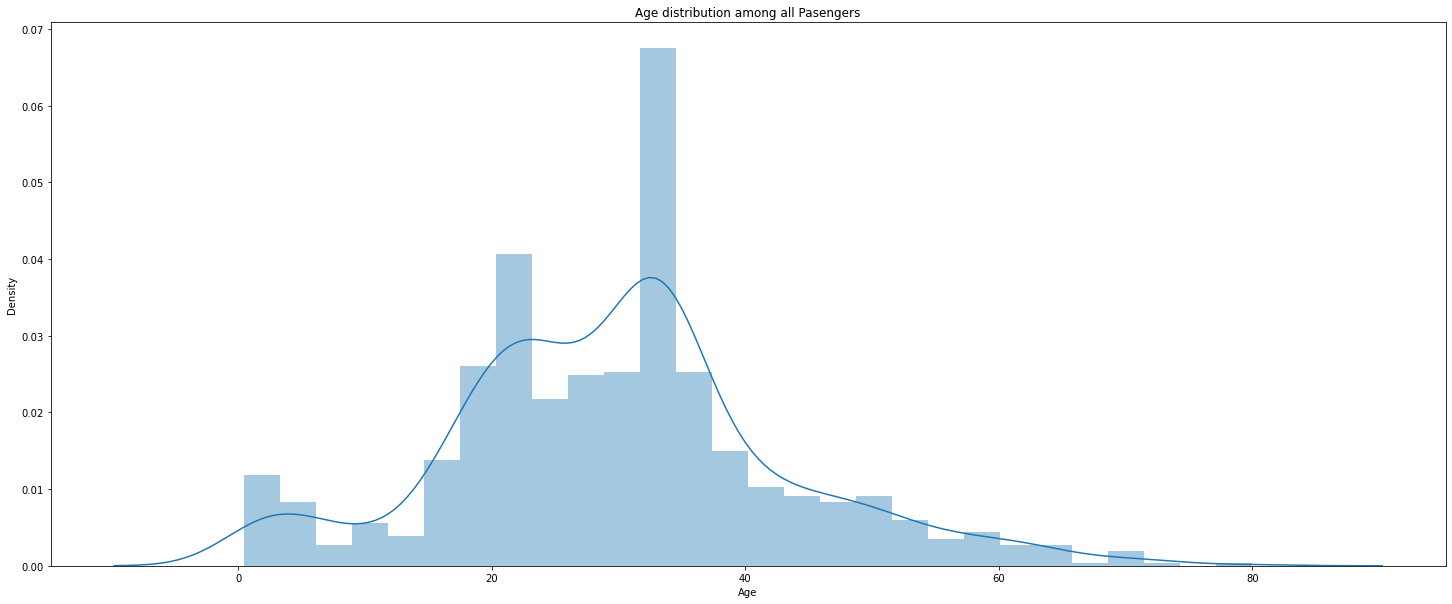

In [22]:
plt.figure(figsize=(25,10))
plt.title('Age distribution among all Pasengers')
sns.distplot(pdf_sdf_train['Age'])

C:\Users\risha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


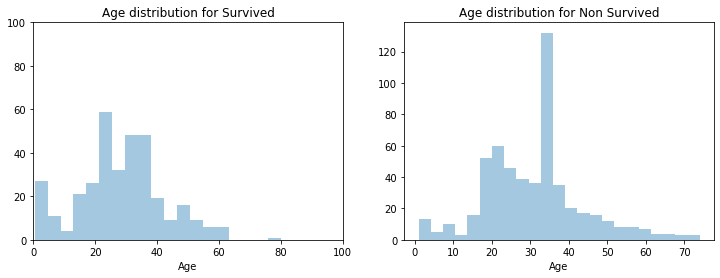

In [23]:
plt.subplot(1,2,1)
# plt.figure(figsize=(25,10))
plt.title('Age distribution for Survived')
plt.axis([0,100,0,100])
sns.distplot(pdf_sdf_train[pdf_sdf_train.Survived == 1]['Age'],kde=False)

plt.subplot(1,2,2)
plt.title('Age distribution for Non Survived')
sns.distplot(pdf_sdf_train[pdf_sdf_train.Survived == 0]['Age'],kde=False)

plt.subplots_adjust(right=1.7)
plt.show()

C:\Users\risha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\risha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


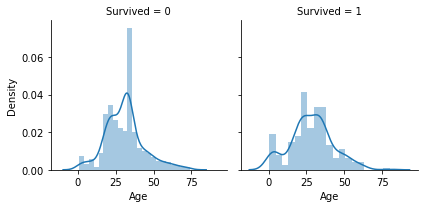

In [24]:
g = sns.FacetGrid(pdf_sdf_train,col='Survived')
g = g.map(sns.distplot,'Age')

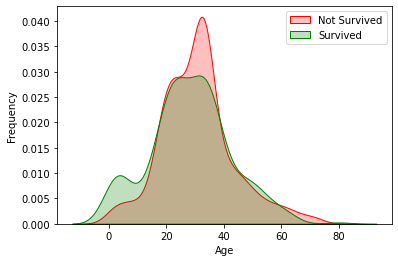

In [25]:
g = sns.kdeplot(pdf_sdf_train['Age']
                [(pdf_sdf_train['Survived']==0) 
                                     & (pdf_sdf_train['Age'].notnull())],
                color='Red',shade=True)
g = sns.kdeplot(pdf_sdf_train['Age']
                [(pdf_sdf_train['Survived']==1)  
                                     & (pdf_sdf_train['Age'].notnull())],
                color='Green',shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

<AxesSubplot:xlabel='Survived', ylabel='Age'>

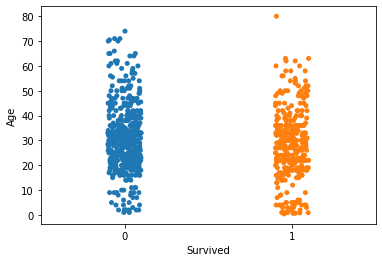

In [26]:
sns.stripplot(x="Survived", y="Age",data=pdf_sdf_train,jitter=True)

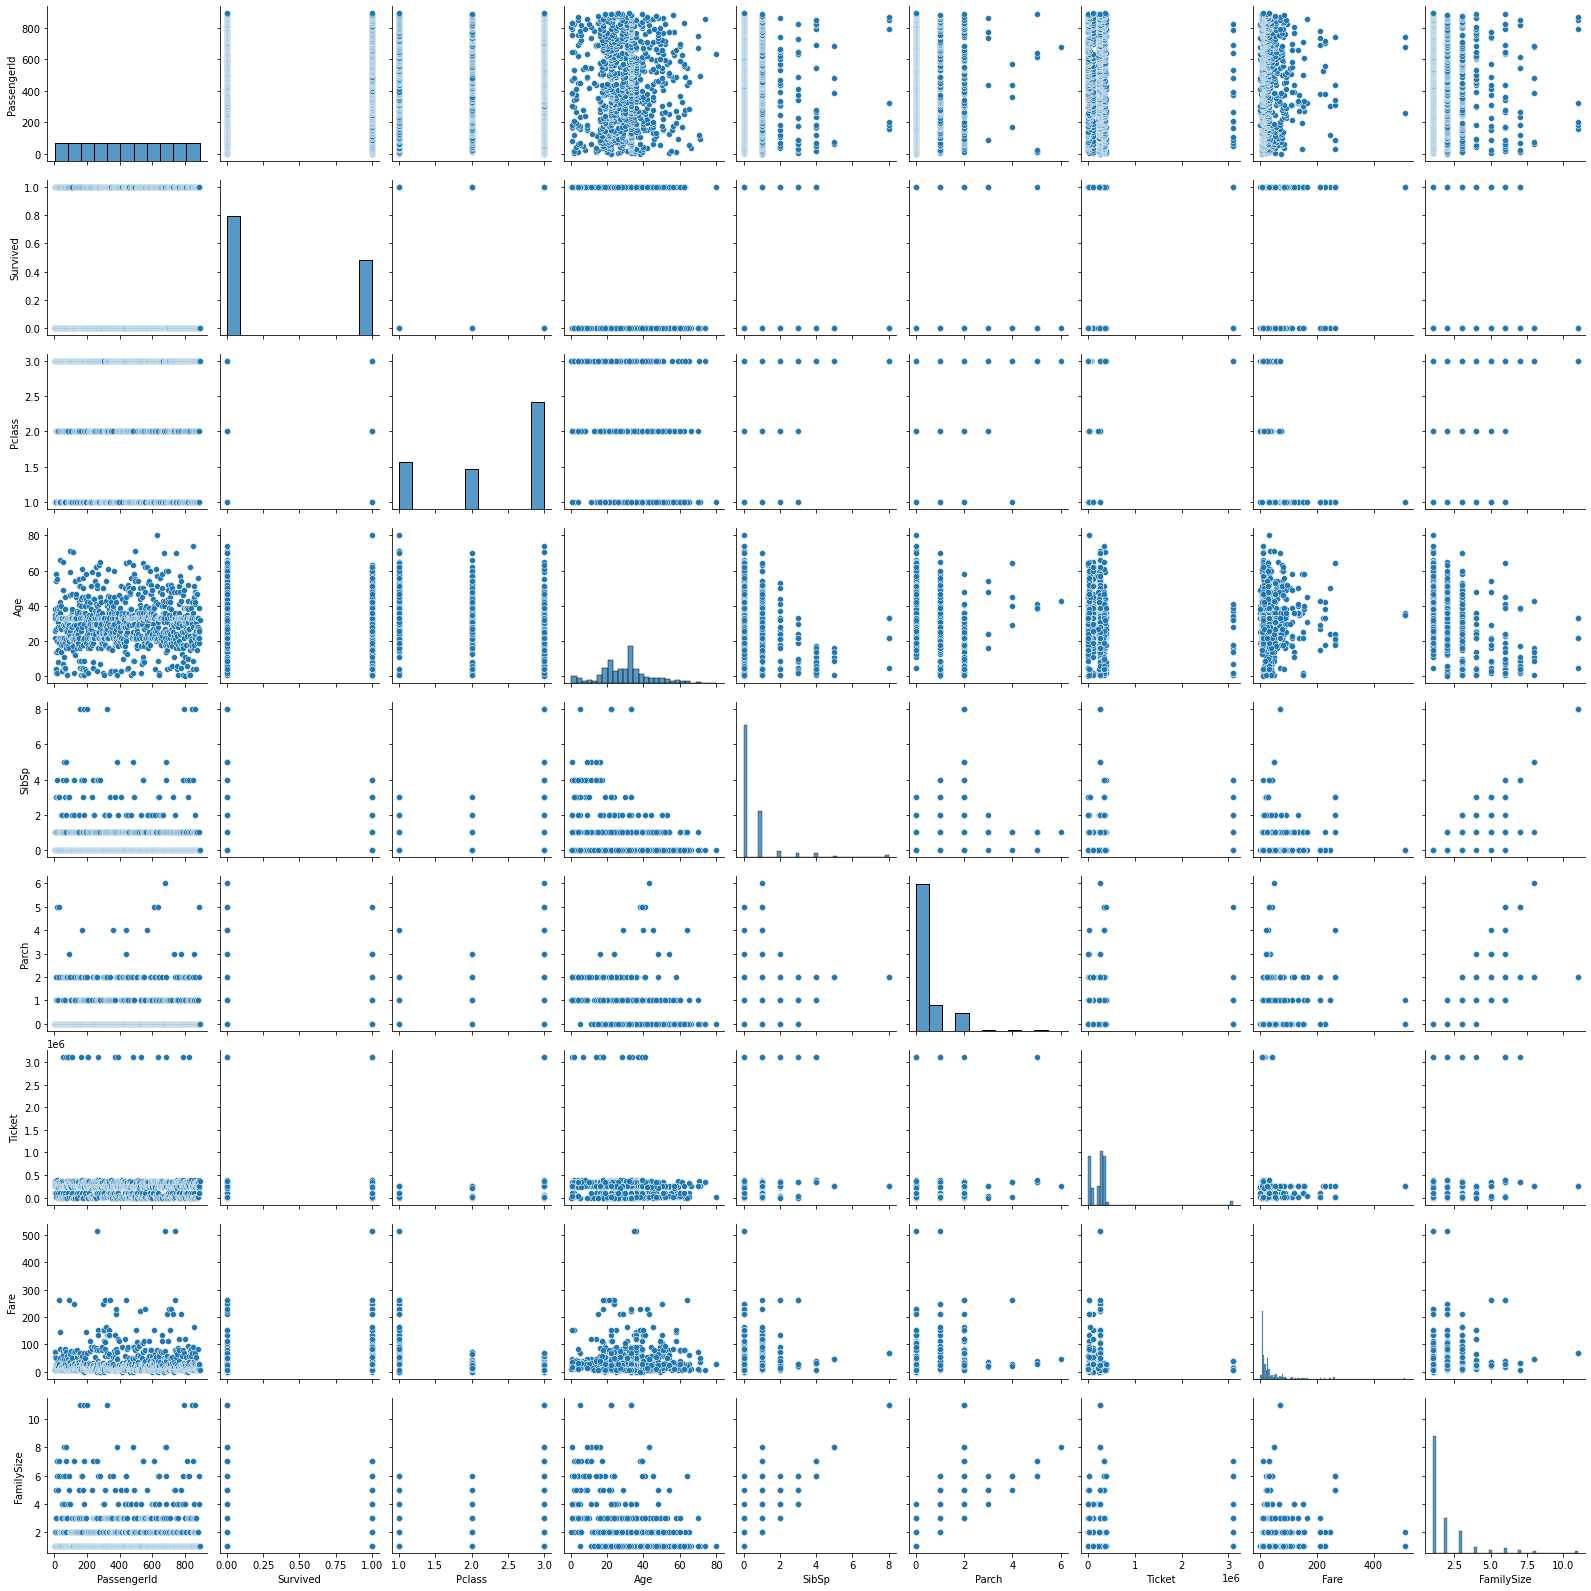

In [27]:
sns.pairplot(pdf_sdf_train)

# Analysing Multiple Machine Learning Model With PySpark

## I Used Logistic Regression, Decision Tree, Random Forest and Gradient-Boosted Tree algorithms to analyse which algorithm performed best on the bank dataset.

### Importing data from local storage

In [28]:
for dirname, _, filenames in os.walk(r'C:\Users\risha\OneDrive\Desktop\pyspark\Binary classification on Bank Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\risha\OneDrive\Desktop\pyspark\Binary classification on Bank Dataset\bank.csv


## Exploring Dataset
### Our goal is to predict whether the client will subscribe to a term deposit or not.

In [29]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Analysing_Multiple_Machine_Learning_Model_on_Bank_Dataset').getOrCreate()
sdf = spark.read.csv(r'C:\Users\risha\OneDrive\Desktop\pyspark\Binary classification on Bank Dataset\bank.csv', header = True, inferSchema = True)
sdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [30]:
sdf.count()

11162

Have a peek of the first five observations


In [31]:
pd.DataFrame(sdf.take(5), columns=sdf.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


Dataset is perfect balanced.

In [32]:
sdf.toPandas().groupby(['deposit']).size()

deposit
no     5873
yes    5289
dtype: int64

Summary statistics for numeric variables

In [33]:
numeric_features = [t[0] for t in sdf.dtypes if t[1] == 'int']
sdf.select(numeric_features).describe().toPandas()

,summary,age,balance,day,duration,campaign,pdays,previous
0,count,11162,11162,11162,11162,11162,11162,11162
1,mean,41.231947679627304,1528.5385235620856,15.658036194230425,371.99381831213043,2.508421429851281,51.33040673714388,0.8325568894463358
2,stddev,11.913369192215518,3225.413325946149,8.420739541006462,347.12838571630687,2.7220771816614824,108.75828197197717,2.292007218670508
3,min,18,-6847,1,2,1,-1,0
4,max,95,81204,31,3881,63,854,58


Correlations between independent variables

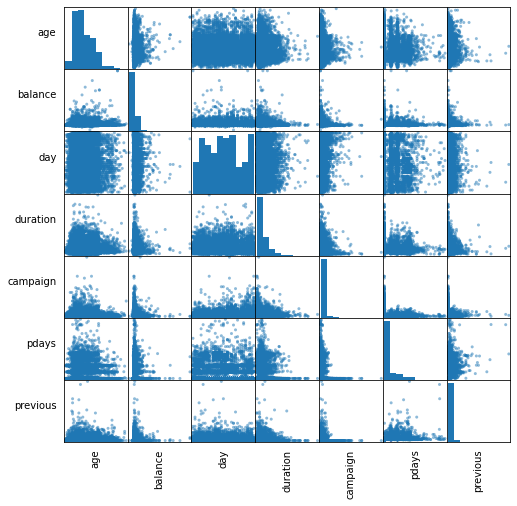

In [34]:
numeric_data = sdf.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

We can see that there aren’t highly correlated numeric variables. Therefore, we will keep all of them for the model.



The day and month columns are not really useful, we will remove these two columns.

In [35]:
sdf = sdf.select(
    'age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 
    'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit'
)
cols = sdf.columns
sdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



## Preparing Dataset for Machine Learning

We Category Indexing, One-Hot Encoding and VectorAssembler

In [36]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

stages = []
categoricalColumns = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'
]

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(
        inputCols=[stringIndexer.getOutputCol()], 
        outputCols=[categoricalCol + "classVec"]
    )
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

We use Pipeline to chain multiple Transformers and Estimators together to specify the Machine Learning workflow.

In [37]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(sdf)
sdf = pipelineModel.transform(sdf)
selectedCols = ['label', 'features'] + cols
sdf = sdf.select(selectedCols)
sdf.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [38]:
pdf = pd.DataFrame(sdf.take(5), columns=sdf.columns)
pdf.iloc[:,0:2] 

,label,features
0,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


We are Randomly spliting data into train and test sets

In [39]:
train, test = sdf.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


## Logistic Regression Model

In [40]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=100)
lrModel = lr.fit(train)

We are obtaining the coefficients

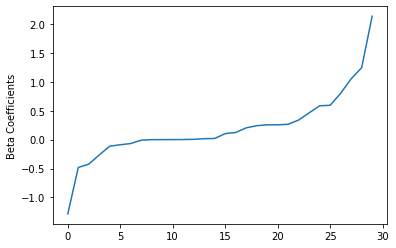

In [41]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

We are Summarizing the model over the training set with the help of Area under Receiver-Operating Characteristics(ROC)

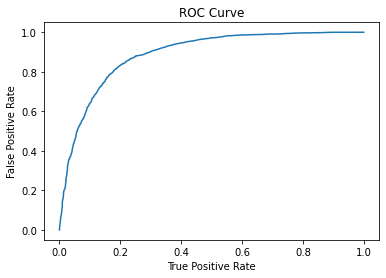

Training set areaUnderROC: 0.887908023812687


In [42]:
trainingSummary = lrModel.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Precision and recall

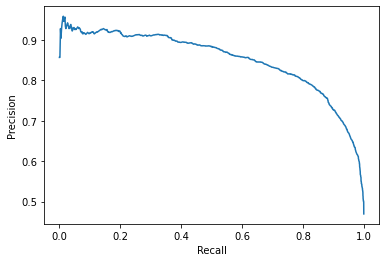

In [43]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Make predictions on the test set

In [44]:
lrPreds = lrModel.transform(test)
lrPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(800)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 33| management|  0.0|[1.91889531585575...|       0.0|[0.87201519640346...|
| 49| management|  0.0|[1.92010568650249...|       0.0|[0.87215021863489...|
| 52| management|  0.0|[-0.7779866740383...|       1.0|[0.31475396602963...|
| 53| management|  0.0|[0.94350506563006...|       0.0|[0.71980712031390...|
| 58| management|  0.0|[2.43515277540257...|       0.0|[0.91946889999110...|
| 32| management|  0.0|[1.27308808959125...|       0.0|[0.78127091960318...|
| 57| management|  0.0|[1.05374265495961...|       0.0|[0.74149294376753...|
| 52| management|  0.0|[3.23621156480951...|       0.0|[0.96217447146724...|
| 46| management|  0.0|[2.23585557449833...|       0.0|[0.90342346328344...|
| 31| management|  0.0|[1.44100073423869...|       0.0|[0.80860957303330...|

Evaluate the Logistic Regression model

In [45]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lrEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', lrEval.evaluate(lrPreds))

Test Area Under ROC 0.8856102407750717


Decision Tree Classifier

In [46]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
dtPreds = dtModel.transform(test)
dtPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(800)

+---+-----------+-----+--------------+----------+--------------------+
|age|        job|label| rawPrediction|prediction|         probability|
+---+-----------+-----+--------------+----------+--------------------+
| 33| management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 49| management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52| management|  0.0|[520.0,1931.0]|       1.0|[0.21215830273357...|
| 53| management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 58| management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 32| management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 57| management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52| management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 46| management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 31| management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 50| management|  0.0|[520.0,1931.0]|       1.0|[0.21215830273357...|
| 40| 

Evaluate the Decision Tree model

In [47]:
dtEval = BinaryClassificationEvaluator()
dtROC = dtEval.evaluate(dtPreds, {dtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(dtROC))

Test Area Under ROC: 0.7808118726917547


Our decision tree performed poorly because it is too weak given the range of different features. The prediction accuracy of decision trees can be improved by Ensemble methods, such as Random Forest and Gradient-Boosted Tree.

Random Forest Classifier

In [48]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
rfPreds = rfModel.transform(test)
rfPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(800)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 33| management|  0.0|[15.4061520522157...|       0.0|[0.77030760261078...|
| 49| management|  0.0|[14.9607992592540...|       0.0|[0.74803996296270...|
| 52| management|  0.0|[6.75259992994703...|       1.0|[0.33762999649735...|
| 53| management|  0.0|[14.3690690962274...|       0.0|[0.71845345481137...|
| 58| management|  0.0|[15.9692636035302...|       0.0|[0.79846318017651...|
| 32| management|  0.0|[15.5507797838150...|       0.0|[0.77753898919075...|
| 57| management|  0.0|[15.2174925525841...|       0.0|[0.76087462762920...|
| 52| management|  0.0|[17.3950516464583...|       0.0|[0.86975258232291...|
| 46| management|  0.0|[16.8864939360929...|       0.0|[0.84432469680464...|
| 31| management|  0.0|[15.8098962041871...|       0.0|[0.79049481020935...|

Evaluate the Random Forest Classifier

In [49]:
rfEval = BinaryClassificationEvaluator()
rfROC = rfEval.evaluate(rfPreds, {rfEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(rfROC))

Test Area Under ROC: 0.874776131314817


Gradient-Boosted Tree Classifier

In [50]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
gbtPreds = gbtModel.transform(test)
gbtPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(800)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 33| management|  0.0|[0.94992370947246...|       0.0|[0.86987425549896...|
| 49| management|  0.0|[1.28281748604659...|       0.0|[0.92861688965145...|
| 52| management|  0.0|[-0.5021429054421...|       1.0|[0.26809961471379...|
| 53| management|  0.0|[0.09646513340517...|       0.0|[0.54808351175538...|
| 58| management|  0.0|[1.05831377292163...|       0.0|[0.89250881497055...|
| 32| management|  0.0|[0.57268875896254...|       0.0|[0.75866558918304...|
| 57| management|  0.0|[0.34932946844840...|       0.0|[0.66789037418062...|
| 52| management|  0.0|[1.33264456943866...|       0.0|[0.93494709840561...|
| 46| management|  0.0|[1.28262818068783...|       0.0|[0.92859178839697...|
| 31| management|  0.0|[1.16094954405484...|       0.0|[0.91067454521219...|

Evaluate the Gradient-Boosted Tree Classifier

In [51]:
gbtEval = BinaryClassificationEvaluator()
gbtROC = gbtEval.evaluate(gbtPreds, {gbtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(gbtROC))

Test Area Under ROC: 0.8935091626908479


we are tuning the model with the help of ParamGridbuilder and crossvalidator

In [52]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=gbtEval, numFolds=5)

cvModel = cv.fit(train)
cvPreds = cvModel.transform(test)
gbtEval.evaluate(cvPreds)

0.8954659543871663